# Meetups in dublin (2018)

This project analyzes the Meetup event network in Dublin (2018), based on data collected through the Meetup.com API. Each node represents a single event, and edges connect events that share participants.

Edge weights reflect the normalized number of shared users.

To reduce noise and highlight strong relationships, we applied a threshold of 0.05: only edges with weight above this value were kept.

We explored the structural and dynamic properties of the network, focusing on the differences between Tech and Non-Tech communities. The goal was to understand how these two domains differ in terms of connectivity, centrality, clustering, and long-term visibility.

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
network_path = "/content/drive/MyDrive/meetup-normalised-comembership.edges"

def read_weighted_edgelist(in_path):
    G = nx.Graph()
    with open(in_path, "r") as f:
        for line in f:
            u, v, w = line.strip().split()
            G.add_edge(int(u), int(v), weight=float(w))
    return G

# graph
G = read_weighted_edgelist(network_path)
print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph loaded: 1481 nodes, 708163 edges


In [6]:
metadata_path = "/content/drive/MyDrive/meetup-metadata.csv"

df_meta = pd.read_csv(metadata_path, sep="|")

# 'categories' to list
import ast
df_meta['categories'] = df_meta['categories'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

df_meta = df_meta[df_meta['description'].notnull()]

df_meta[['meetup_id', 'name', 'categories']].head()

,meetup_id,name,categories
0,370896,New and Not So New In Dublin,[Socializing]
1,8749202,20-35 Somethin's,[Socializing]
2,19190729,Machine Learning Dublin,[Tech]
3,28444095,Data Science Festival - Dublin,[Tech]
4,11686062,"Events, Drinks and Dancing in Dublin",[Socializing]


In [7]:
# remove weak edges (weight<0.05)
threshold = 0.05
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < threshold]
G.remove_edges_from(edges_to_remove)

# Statistics
print(f" Removed {len(edges_to_remove)} weak edges")
print(f" New graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f" Density: {nx.density(G):.4f}")
print(f" Number of connected components: {nx.number_connected_components(G)}")


 Removed 701407 weak edges
 New graph: 1481 nodes, 6756 edges
 Density: 0.0062
 Number of connected components: 409


After applying a threshold of 0.05 to filter out weak ties from the weighted co-membership network, a total of 701,407 edges were removed. The resulting network contains:

1481 nodes

6756 edges

A density of 0.0062, indicating a very sparse network

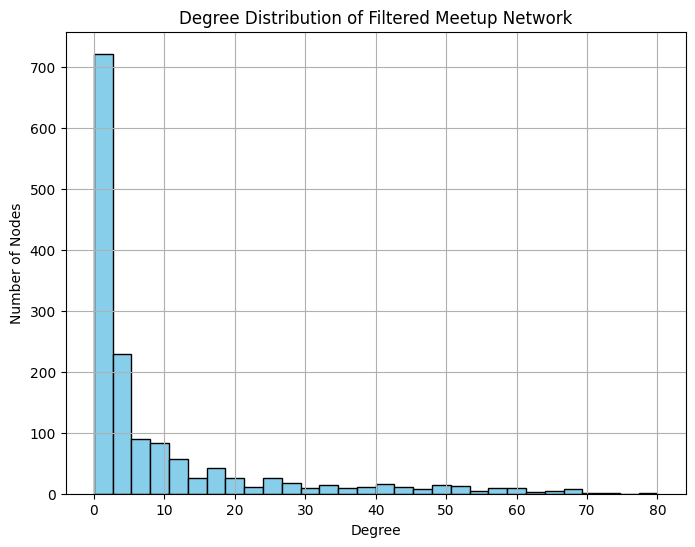

Degree - min: 0, max: 80, avg: 9.12


In [8]:
# Degree distribution
degrees = [d for n, d in G.degree()]
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution of Filtered Meetup Network")
plt.grid(True)
plt.show()

print(f"Degree - min: {min(degrees)}, max: {max(degrees)}, avg: {sum(degrees)/len(degrees):.2f}")


The degree distribution of the filtered network is highly right-skewed, with the majority of nodes having a very low degree (1–5 connections), while a small number of nodes exhibit much higher degrees (hubs with 70+ connections).

This heavy-tailed distribution is typical in social networks and suggests the presence of popular or central events that attract diverse groups of participants.

In [9]:
stopwords_path = "/content/drive/MyDrive/stopwords.txt"

with open(stopwords_path, "r") as f:
    custom_stopwords = [word.strip() for word in f.readlines()]


print(f"Loaded {len(custom_stopwords)} custom stopwords.")

Loaded 388 custom stopwords.


In [10]:
df_meta.set_index("Id", inplace=True)

In [11]:
threshold = 0.05
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < threshold]
G.remove_edges_from(edges_to_remove)
print(f" Removed {len(edges_to_remove)} weak edges. New graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

 Removed 0 weak edges. New graph: 1481 nodes, 6756 edges


# Semantic Analysis of Communities Using TF-IDF

To better understand the topics discussed in each community, we performed a semantic analysis based on the names and descriptions of Meetup groups.

We used TF-IDF (Term Frequency–Inverse Document Frequency), a technique that highlights the most important words in a text by giving more weight to terms that are specific and less common. This helps us find the key terms that best describe each community.

By averaging the TF-IDF vectors of all groups in a community, we identified the top terms that summarize its main themes.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import numpy as np

token_pattern = re.compile(r"\b\w\w+\b", re.U)

def custom_tokenizer(s, min_term_length=2):
    return [x for x in token_pattern.findall(s) if len(x) >= min_term_length and not x.isnumeric()]

def preprocess(docs, stopwords):
    tfidf = TfidfVectorizer(stop_words=stopwords, lowercase=True,
                            tokenizer=custom_tokenizer, strip_accents="unicode",
                            use_idf=True, norm="l2", min_df=3)
    X = tfidf.fit_transform(docs)


    vocab = tfidf.vocabulary_
    terms = [""] * len(vocab)
    for term, idx in vocab.items():
        terms[idx] = term
    return X, terms

name_documents = list(df_meta["name"])
desc_documents = list(df_meta["description"])

X_name, name_terms = preprocess(name_documents, custom_stopwords)
X_desc, desc_terms = preprocess(desc_documents, custom_stopwords)

top_terms = 10
name_labels, desc_labels = {}, {}

for i, comm in enumerate(communities):
    name_centroid = np.zeros(X_name.shape[1])
    desc_centroid = np.zeros(X_desc.shape[1])

    for node in comm:
        row = node - 1  # ATTENZIONE: gli ID nei file partono da 1
        name_centroid += X_name[row].toarray().flatten()
        desc_centroid += X_desc[row].toarray().flatten()

    name_centroid /= len(comm)
    desc_centroid /= len(comm)

    # Top terms
    top_name_idx = np.argsort(name_centroid)[::-1][:top_terms]
    top_desc_idx = np.argsort(desc_centroid)[::-1][:top_terms]

    name_labels[i+1] = ", ".join([name_terms[j] for j in top_name_idx])
    desc_labels[i+1] = ", ".join([desc_terms[j] for j in top_desc_idx])

In [37]:
import pandas as pd

df_comm = pd.DataFrame({
    "Size": [len(c) for c in communities],
    f"Top {top_terms} Name Terms": pd.Series(name_labels),
    f"Top {top_terms} Description Terms": pd.Series(desc_labels)
})

df_comm.index.name = "Community"
df_comm.head()

,Size,Top 10 Name Terms,Top 10 Description Terms
Community,,,
1,155,"international, dancing, travel, photography, h...","fun, friends, dance, photography, friendly, fr..."
2,144,"user, data, tech, learning, engineering, scien...","data, programming, developers, community, lear..."
3,114,"business, startup, marketing, entrepreneurs, d...","business, marketing, entrepreneurs, design, st..."
4,28,"blockchain, crypto, technology, development, t...","blockchain, crypto, bitcoin, ethereum, technol..."
5,15,"games, night, fun, board, chess, reality, game...","games, board, fun, play, game, players, playin..."


In [38]:
from collections import defaultdict

global_cat_counts = defaultdict(int)
for cats in df_meta["categories"]:
    for cat in cats:
        global_cat_counts[cat] += 1

def select_dict_top(d, top=3):
    sorted_items = sorted(d.items(), key=lambda x: x[1], reverse=True)
    return ", ".join([f"{k} ({v:.2f})" for k, v in sorted_items[:top]])

comm_precision, comm_recall, comm_f1 = {}, {}, {}

for i, comm in enumerate(communities):
    comm_cats = defaultdict(int)

    for node in comm:
        for cat in df_meta.loc[node]["categories"]:

            comm_cats[cat] += 1

    precision, recall, f1 = {}, {}, {}
    for cat in comm_cats:
        precision[cat] = comm_cats[cat] / len(comm)
        recall[cat] = comm_cats[cat] / global_cat_counts[cat]
        f1[cat] = 2 * (precision[cat] * recall[cat]) / (precision[cat] + recall[cat])

    comm_precision[i + 1] = select_dict_top(precision)
    comm_recall[i + 1] = select_dict_top(recall)
    comm_f1[i + 1] = select_dict_top(f1)

df_comm["Top 3 Category Precision"] = pd.Series(comm_precision)
df_comm["Top 3 Category Recall"] = pd.Series(comm_recall)
df_comm["Top 3 Category F1"] = pd.Series(comm_f1)

df_comm.head()

,Size,Top 10 Name Terms,Top 10 Description Terms,Top 3 Category Precision,Top 3 Category Recall,Top 3 Category F1
Community,,,,,,
1,155,"international, dancing, travel, photography, h...","fun, friends, dance, photography, friendly, fr...","Cars & Motorcycles (0.20), Outdoors & Adventur...","Photography (0.90), Movies & Film (0.47), Cars...","Cars & Motorcycles (0.28), Outdoors & Adventur..."
2,144,"user, data, tech, learning, engineering, scien...","data, programming, developers, community, lear...","Tech (0.95), Education & Learning (0.03), Comm...","Tech (0.41), Education & Learning (0.10), Comm...","Tech (0.57), Education & Learning (0.04), Comm..."
3,114,"business, startup, marketing, entrepreneurs, d...","business, marketing, entrepreneurs, design, st...","Career & Business (0.60), Tech (0.36), Educati...","Career & Business (0.46), Tech (0.12), Communi...","Career & Business (0.52), Tech (0.18), Communi..."
4,28,"blockchain, crypto, technology, development, t...","blockchain, crypto, bitcoin, ethereum, technol...","Tech (0.89), Career & Business (0.11)","Tech (0.07), Career & Business (0.02)","Tech (0.14), Career & Business (0.03)"
5,15,"games, night, fun, board, chess, reality, game...","games, board, fun, play, game, players, playin...","Games (0.80), Sci-Fi & Fantasy (0.80), Sociali...","Games (0.46), Sci-Fi & Fantasy (0.46), Hobbies...","Games (0.59), Sci-Fi & Fantasy (0.59), Hobbies..."


This analysis confirms the semantic coherence and thematic purity of the detected communities. For example,

Community 2 is strongly tech-oriented, as confirmed by both the top terms ("data", "tech", "developers") and its very high precision (0.95) in the Tech category.

Community 5 focuses on board games and fantasy themes, with consistent scores in Games and Sci-Fi & Fantasy, demonstrating coherence in both semantic and categorical terms.


# Community detection

In [32]:
!pip install -q python-louvain
import community.community_louvain as community_louvain
from collections import defaultdict

partition = community_louvain.best_partition(G, weight='weight')


communities_dict = defaultdict(set)
for node, comm_id in partition.items():
    communities_dict[comm_id].add(node)

communities = list(communities_dict.values())

min_size = 5
communities = [c for c in communities if len(c) >= min_size]
print(f" {len(communities)} communities retained with ≥{min_size} nodes.")

 21 communities retained with ≥5 nodes.


In [56]:
modularity_score = community_louvain.modularity(partition, G, weight='weight')
print(f"Modularity (Q) of the Louvain partition: {modularity_score:.4f}")


Modularity (Q) of the Louvain partition: 0.6789



The modularity of our partition is Q = 0.6789, indicating a very strong modular structure. This confirms that the detected communities are not random, but represent meaningful clusters with dense internal connections and sparse connections between them.

Top community IDs: [0, 32, 1, 2, 25]


<ipython-input-76-f8cba9d0cfc3>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(top_communities_ids))


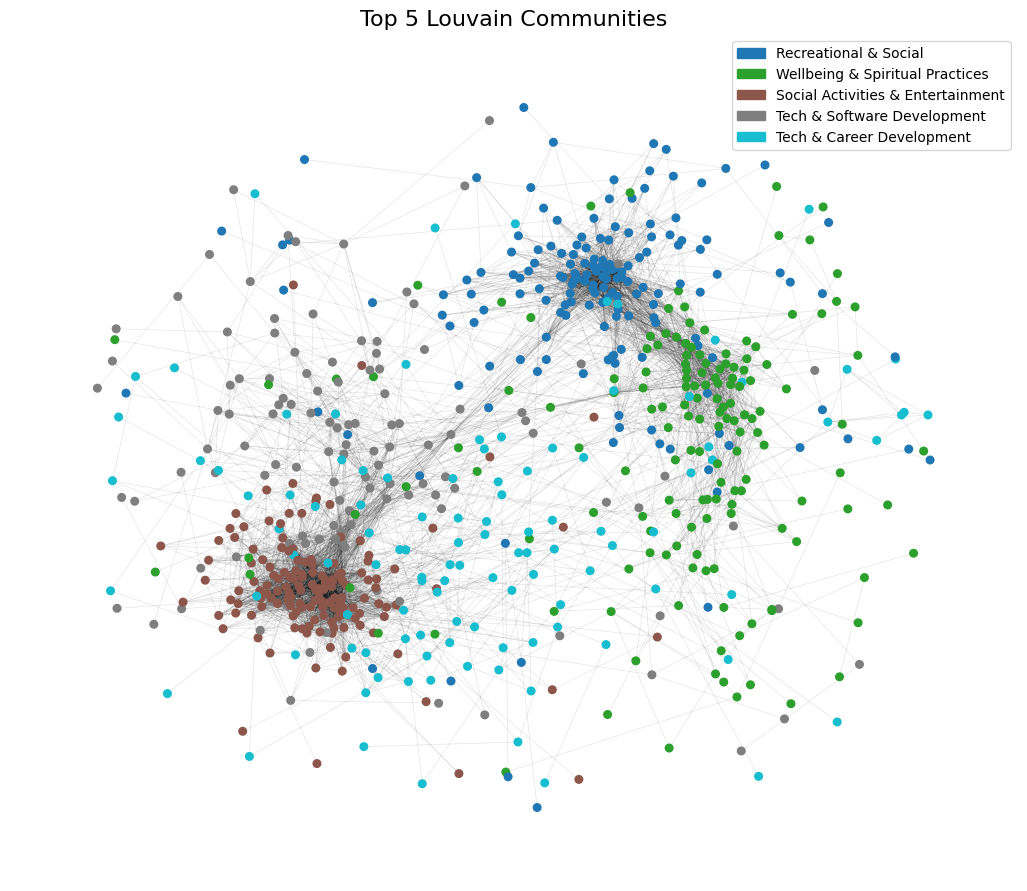

In [76]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from collections import Counter
import networkx as nx
from matplotlib.patches import Patch

# Compute node layout
pos = nx.spring_layout(G, seed=42, k=0.15, iterations=100)

# Top 5 real communities
top_communities_ids = [cid for cid, _ in Counter(partition.values()).most_common(5)]
print("Top community IDs:", top_communities_ids)

# Filter graph to only nodes in top communities
top_nodes = [node for node, cid in partition.items() if cid in top_communities_ids]
G_top = G.subgraph(top_nodes)

# Map node → community (only top ones)
partition_top = {node: partition[node] for node in G_top.nodes}

# Assign colors
color_map = {}
cmap = cm.get_cmap("tab10", len(top_communities_ids))
for i, cid in enumerate(top_communities_ids):
    color_map[cid] = cmap(i)

# Color each node according to its community
node_colors = [color_map[partition_top[n]] for n in G_top.nodes]

# Semantic labels based on TF-IDF and category analysis
semantic_labels = {
    0: "Recreational & Social",
    1: "Social Activities & Entertainment",
    2: "Tech & Software Development",
    25: "Tech & Career Development",
    32: "Wellbeing & Spiritual Practices"
}

# Updated legend with semantic labels
legend_patches = [
    Patch(color=color_map[cid], label=semantic_labels.get(cid, f"Community {cid}"))
    for cid in top_communities_ids
]

# Plot
plt.figure(figsize=(13, 11))
nx.draw_networkx_edges(G_top, pos, alpha=0.1, width=0.5)
nx.draw_networkx_nodes(G_top, pos, node_color=node_colors, node_size=30)
plt.title("Top 5 Louvain Communities", fontsize=16)
plt.legend(handles=legend_patches, loc="upper right")
plt.axis("off")
plt.show()



In [83]:
import numpy as np
from collections import Counter
import networkx as nx

top_community_ids = [0, 32, 1, 2, 25]

# 1. Internal vs External edges
def compute_internal_external_edges(G, community_nodes):
    internal_edges = 0
    external_edges = 0
    community_set = set(community_nodes)

    for u in community_nodes:
        for v in G.neighbors(u):
            if v in community_set:
                internal_edges += 1
            else:
                external_edges += 1

    internal_edges = internal_edges // 2  # Undirected graph
    return internal_edges, external_edges

# 2. Betweenness centrality
centrality = nx.betweenness_centrality(G)

# 3. Loop through each community
for comm_id in top_community_ids:
    community_nodes = communities_dict[comm_id]
    G_sub = G.subgraph(community_nodes)

    internal, external = compute_internal_external_edges(G, community_nodes)
    external_ratio = external / (internal + external)
    density = nx.density(G_sub)
    comm_centrality = [centrality[n] for n in community_nodes]
    avg_centrality = np.mean(comm_centrality)

    #  Output
    print(f"\nCommunity {comm_id} analysis:")
    print(f"- Number of nodes: {len(community_nodes)}")
    print(f"- Internal edges: {internal}")
    print(f"- External edges: {external}")
    print(f"- External / Total edge ratio: {external_ratio:.2f}")
    print(f"- Internal density: {density:.4f}")
    print(f"- Avg. betweenness centrality: {avg_centrality:.4f}")




Community 0 analysis:
- Number of nodes: 164
- Internal edges: 1347
- External edges: 352
- External / Total edge ratio: 0.21
- Internal density: 0.1008
- Avg. betweenness centrality: 0.0024

Community 32 analysis:
- Number of nodes: 155
- Internal edges: 989
- External edges: 281
- External / Total edge ratio: 0.22
- Internal density: 0.0829
- Avg. betweenness centrality: 0.0025

Community 1 analysis:
- Number of nodes: 144
- Internal edges: 2076
- External edges: 440
- External / Total edge ratio: 0.17
- Internal density: 0.2016
- Avg. betweenness centrality: 0.0018

Community 2 analysis:
- Number of nodes: 118
- Internal edges: 469
- External edges: 326
- External / Total edge ratio: 0.41
- Internal density: 0.0679
- Avg. betweenness centrality: 0.0029

Community 25 analysis:
- Number of nodes: 111
- Internal edges: 236
- External edges: 173
- External / Total edge ratio: 0.42
- Internal density: 0.0387
- Avg. betweenness centrality: 0.0011


### Research Question: Do thematically coherent communities exist within Dublin’s Meetup ecosystem?
Our analysis clearly gives a positive answer.

We used the Louvain algorithm to find communities in a network of Meetup groups in Dublin, based on shared members. This gave us 21 communities, each with at least five groups. To check how consistent these communities are in terms of topics, we used TF-IDF to find important words in each group’s name and description.

We looked closely at the five biggest communities, each shown in a different color on the graph. They are some of the most active parts of the network. However, their structure is very different depending on the type of topic they focus on.

### Community summaries:
Community 0 – Outdoor & Social Activities
This group includes Meetups about outdoor trips, cars, dancing, photography, and social events.
→ It has high internal density (0.1008) and low external connections (0.21), meaning members mostly connect with others in the same group.

Community 1 – Social & Leisure
Found in the lower middle part of the network, this group includes dancing, cinema, hiking, and photography → It is the most cohesive community, with the highest internal density (0.2016) and lowest external ratio (0.17), showing very strong internal links.

Community 2 – Programming & Software Development
This tech-focused group includes coding Meetups and developer events.
→ It has lower internal density (0.0679) and high external connections (0.41), meaning members are more spread out and also join other groups.

Community 25 – Tech & Career Bridge
This group mixes Tech with Business & Career themes.
→ It has the lowest internal density (0.0387) and highest external ratio (0.42), suggesting it acts like a bridge between different tech-related topics.

Community 32 – Wellbeing & Spirituality
This group includes Meetups about health, mindfulness, personal growth, and support.
→ It shows strong internal connections (density 0.0829) and relatively few outside links (0.22), meaning it's a focused and well-connected group.

### Main Insight:

Tech vs Non-Tech Communities
We saw a big difference between Tech and Non-Tech groups:

Non-Tech communities (like 0, 1, and 32) are more compact and connected. Members often meet in person and share strong interests.

Tech communities (like 2 and 25) are more spread out, with many links to other parts of the network. This may be because Tech attracts people with different backgrounds and interests who join more than one group.

You can also see this in the graph: Non-Tech groups form tight clusters, while Tech ones look more scattered.

### Do communities overlap?

Even though the Louvain algorithm gives each group just one community, some results suggest overlaps exist—especially in Tech areas.

Community 25 and Community 2 have low internal density and many connections to other groups. This shows that Tech groups often share members with other topics.

In contrast, Community 1 and Community 32 are more closed and focused, with strong internal ties and few external ones.

→ This suggests that Tech communities are more likely to overlap with others, while Non-Tech communities are more separated and stable.

In future work, we could use methods that allow overlapping communities, like OSLOM or Label Propagation, to study this better.

### Final result: Strong community structure
We measured how good the community division is using the modularity score. We got Q = 0.6789, which is a high value. This means the communities are well defined and based on real, shared interests—not random.

## Tech vs No-Tech

In [84]:
tech_keywords = ["Tech", "Technology", "Software", "AI", "Blockchain", "Programming", "Data", "Machine Learning", "Startup", "Developers"]

def assign_macro_label(cat_list):
    for cat in cat_list:
        if any(keyword.lower() in cat.lower() for keyword in tech_keywords):
            return "Tech"
    return "Non-Tech"

macro_labels = {idx: assign_macro_label(row["categories"]) for idx, row in df_meta.iterrows()}


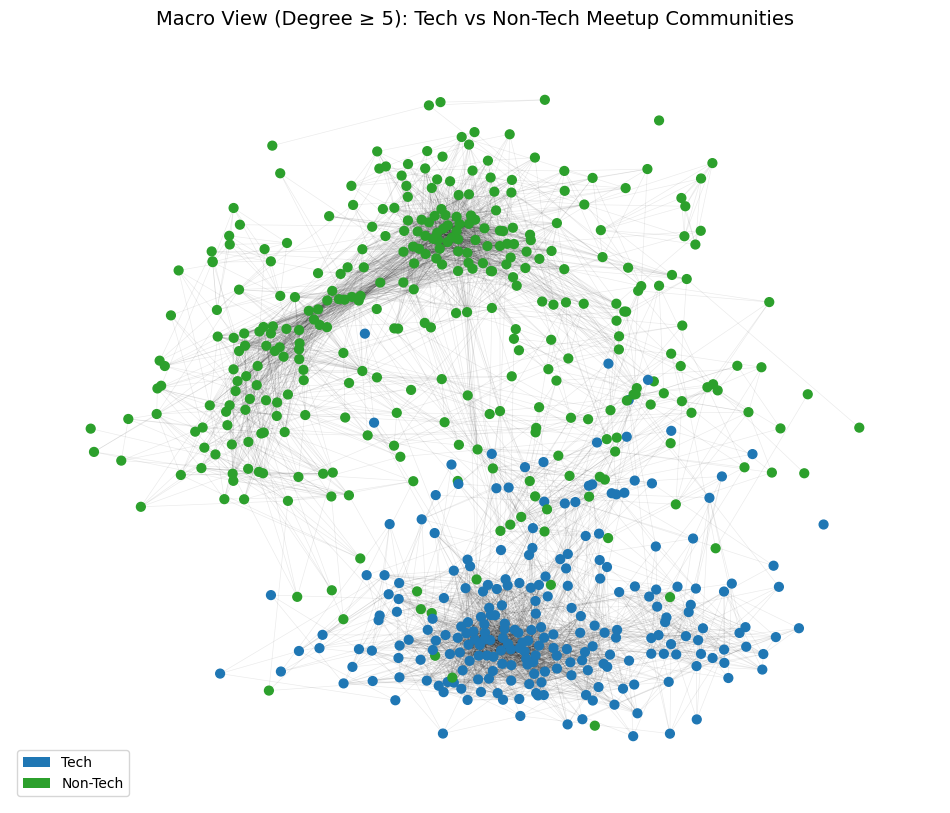

In [85]:
from matplotlib.patches import Patch

macro_nodes = [n for n in G.nodes if n in macro_labels]
G_macro = G.subgraph(macro_nodes)
filtered_nodes = [n for n in G_macro.nodes if G_macro.degree(n) >= 5]
G_macro_filtered = G_macro.subgraph(filtered_nodes)

pos_macro = nx.spring_layout(G_macro_filtered, seed=42, k=0.3, iterations=150)

macro_color_map = {
    "Tech": "#1f77b4",      # blue
    "Non-Tech": "#2ca02c"   # green
}
node_colors = [macro_color_map[macro_labels[n]] for n in G_macro_filtered.nodes]

intra_edges = [(u, v) for u, v in G_macro_filtered.edges if macro_labels[u] == macro_labels[v]]

plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G_macro_filtered, pos_macro, edgelist=intra_edges, alpha=0.08, width=0.5)
nx.draw_networkx_nodes(G_macro_filtered, pos_macro, node_color=node_colors, node_size=40)
plt.title("Macro View (Degree ≥ 5): Tech vs Non-Tech Meetup Communities", fontsize=14)
plt.axis("off")

legend_elements = [
    Patch(facecolor="#1f77b4", label='Tech'),
    Patch(facecolor="#2ca02c", label='Non-Tech')
]
plt.legend(handles=legend_elements, loc='lower left', frameon=True)

plt.show()


As shown, the two domains occupy distinct regions. Tech nodes are densely interlinked in the bottom part of the network, while Non-Tech nodes are positioned above, often forming smaller local clusters.

The layout also highlights a small set of bridge nodes connecting the two areas. To further explore the interaction between Tech and Non-Tech areas, we identified the top 10 “bridge nodes” based on betweenness centrality. These groups play a key structural role by linking otherwise separated domains.

## Analysis of the top 10 “bridge nodes” based on betweenness centrality

In [58]:
betweenness = nx.betweenness_centrality(G_macro_filtered, weight='weight', normalized=True)


In [106]:
bridge_nodes = []
for node in G_macro_filtered.nodes:
    neighbors = list(G_macro_filtered.neighbors(node))
    neighbor_labels = set(macro_labels[n] for n in neighbors if n in macro_labels)

    if "Tech" in neighbor_labels and "Non-Tech" in neighbor_labels:
        bridge_nodes.append(node)


In [105]:
bridge_nodes_sorted = sorted(bridge_nodes, key=lambda n: betweenness[n], reverse=True)


print(" Top 10 Bridge Nodes (Tech <-> Non-Tech):")
for i, node in enumerate(bridge_nodes_sorted[:10]):
    print(f"{i+1}. Node ID {node} – Betweenness: {betweenness[node]:.4f}")


 Top 10 Bridge Nodes (Tech <-> Non-Tech):
1. Node ID 28 – Betweenness: 0.1349
2. Node ID 596 – Betweenness: 0.1112
3. Node ID 307 – Betweenness: 0.0758
4. Node ID 1179 – Betweenness: 0.0560
5. Node ID 90 – Betweenness: 0.0533
6. Node ID 933 – Betweenness: 0.0462
7. Node ID 29 – Betweenness: 0.0435
8. Node ID 706 – Betweenness: 0.0310
9. Node ID 294 – Betweenness: 0.0272
10. Node ID 240 – Betweenness: 0.0248


In [90]:
for node in bridge_nodes_sorted[:10]:
    try:
        name = df_meta.loc[node]["name"]
        description = df_meta.loc[node]["description"]
        print(f"→ {name}\n{description}\n{'-'*80}")
    except KeyError:
        print(f"Node {node} not found in metadata.\n{'-'*80}")



→ Entrepreneurs Anonymous Dublin
Are you interested in becoming an entrepreneur and would like to meet like minded people in the same situation Do you already have your own business but enjoy meeting like minded people learn new things and exchange best practices If yes then you should join Entrepreneurs Anonymous We usually have guest speakers who share their expertise and experience following networking in a nice setting The name Entrepreneurs Anonymous could stand for being addicted to entrepreneurship and having an urgent need to get group support for it But actually Entrepreneurs Anonymous is more about providing a safe place with like minded people where entrepreneurship can be explored Entrepreneurs Anonymous events started in Dublin Ireland in 2011 as accountability group by former students of an entrepreneurship course The interest for the group grew and now social events with guest speakers are organized every last Tuesday of the month With a membership increase by 10 each mo

Several of the top bridge nodes are hybrid groups that mix technology, business, and community themes:

Entrepreneurs Anonymous Dublin and Dublin Startup Founder 101 bring together people starting businesses, often with a tech background, to share ideas and support each other.

Startup Grind Dublin and Dublin Business Creativity & Rulebreaking focus on innovation, helping startup founders and creative thinkers connect across different fields.

Learning Tech Labs and Network Ireland Dublin are open spaces where tech, education, and business networking come together, attracting both tech professionals and people from other areas.

These groups don’t belong only to the Tech or Non-Tech category. Instead, they act as bridges, connecting different parts of the network. Their role shows how important interdisciplinary communities are in the Dublin Meetup scene. They help ideas spread and encourage collaboration across different topics.

In [91]:
tech_nodes = [n for n in G_macro_filtered.nodes if macro_labels[n] == "Tech"]
nontech_nodes = [n for n in G_macro_filtered.nodes if macro_labels[n] == "Non-Tech"]

G_tech = G_macro_filtered.subgraph(tech_nodes).copy()
G_non_tech = G_macro_filtered.subgraph(nontech_nodes).copy()

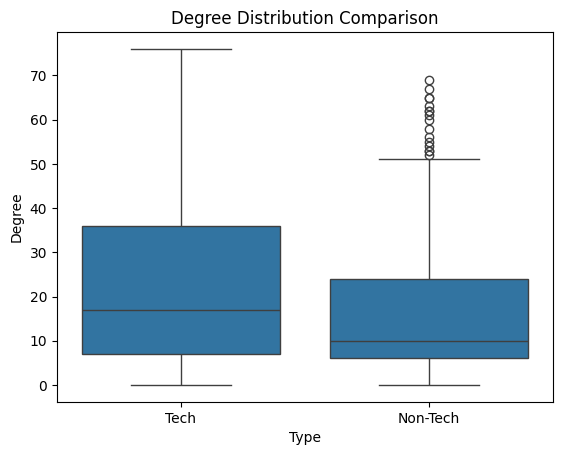

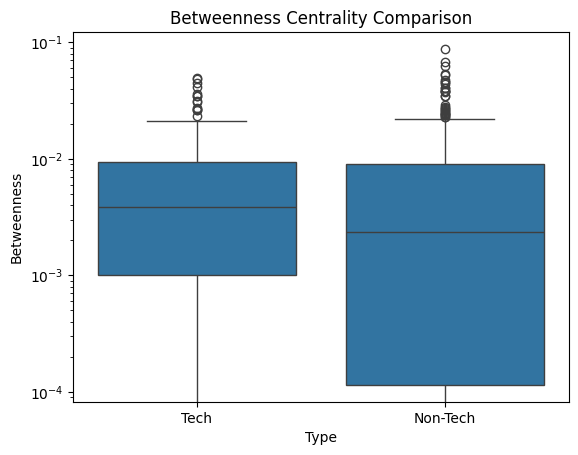

In [92]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


def compute_centralities(G):
    degrees = dict(G.degree())
    betweenness = nx.betweenness_centrality(G, weight='weight')
    return degrees, betweenness

deg_tech, bet_tech = compute_centralities(G_tech)
deg_nontech, bet_nontech = compute_centralities(G_non_tech)


import pandas as pd

df_deg = pd.DataFrame({
    'Degree': list(deg_tech.values()) + list(deg_nontech.values()),
    'Type': ['Tech'] * len(deg_tech) + ['Non-Tech'] * len(deg_nontech)
})

df_bet = pd.DataFrame({
    'Betweenness': list(bet_tech.values()) + list(bet_nontech.values()),
    'Type': ['Tech'] * len(bet_tech) + ['Non-Tech'] * len(bet_nontech)
})

# Plot
sns.boxplot(data=df_deg, x='Type', y='Degree')
plt.title("Degree Distribution Comparison")
plt.show()

sns.boxplot(data=df_bet, x='Type', y='Betweenness')
plt.title("Betweenness Centrality Comparison")
plt.yscale("log")
plt.show()


In [93]:
def graph_stats(G):
    density = nx.density(G)
    clustering = nx.average_clustering(G)
    return density, clustering

dens_tech, clust_tech = graph_stats(G_tech)
dens_nontech, clust_nontech = graph_stats(G_non_tech)

print("Tech Graph:")
print(f"- Density: {dens_tech:.4f}")
print(f"- Avg Clustering Coefficient: {clust_tech:.4f}\n")

print("Non-Tech Graph:")
print(f"- Density: {dens_nontech:.4f}")
print(f"- Avg Clustering Coefficient: {clust_nontech:.4f}")


Tech Graph:
- Density: 0.0962
- Avg Clustering Coefficient: 0.5246

Non-Tech Graph:
- Density: 0.0506
- Avg Clustering Coefficient: 0.5488


This analysis confirms the differences we observed earlier in the macro view of the network.

The Tech graph is more active and interconnected:

It includes more high-degree nodes (up to 75), showing the presence of hubs.

Its density (0.0962) is almost twice that of the Non-Tech network.

The median betweenness centrality is higher, meaning that Tech groups are more often found in central positions that connect different parts of the network.

In contrast, the Non-Tech graph:

Has lower and more uniform degree values, meaning its nodes are less connected overall.

Shows slightly higher clustering (0.5488 vs. 0.5246), which fits our earlier observation that Non-Tech communities are more internally cohesive and compact.

These results support what we saw in both the community-level and macro-level analysis:

Tech communities tend to be more open and bridge different areas.

Non-Tech communities are more focused and form tight, isolated clusters.


# Dinamic analysis

To understand how visible each group is over time, we ran a random walk on the Meetup network and calculated the stationary distribution for both Tech and Non-Tech groups. This tells us how likely it is that a random visitor ends up in each group in the long run.

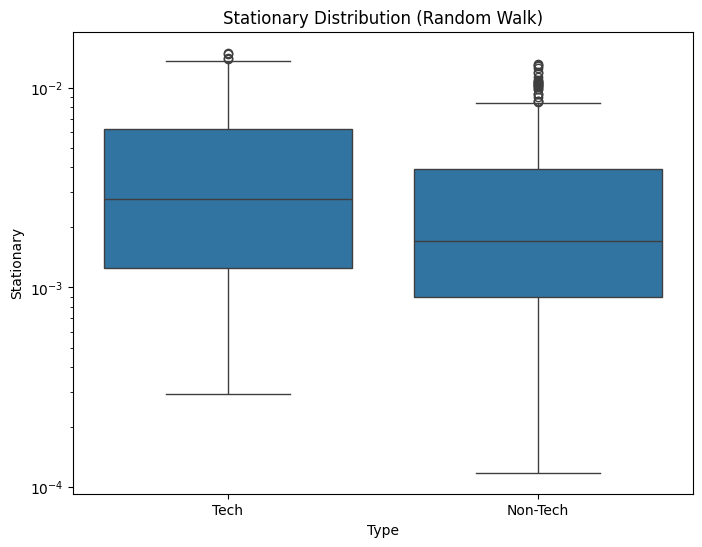

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def random_walk_stationary_distribution(G):
    G = G.copy()
    G.remove_nodes_from(list(nx.isolates(G)))
    A = nx.to_numpy_array(G)
    P = A / A.sum(axis=1, keepdims=True)
    eigvals, eigvecs = np.linalg.eig(P.T)
    idx = np.argmin(np.abs(eigvals - 1))
    stationary = np.real(eigvecs[:, idx])
    stationary /= stationary.sum()
    return dict(zip(G.nodes(), stationary))


stationary_tech = random_walk_stationary_distribution(G_tech)
stationary_nontech = random_walk_stationary_distribution(G_non_tech)


import pandas as pd

df_stat = pd.DataFrame({
    'Stationary': list(stationary_tech.values()) + list(stationary_nontech.values()),
    'Type': ['Tech'] * len(stationary_tech) + ['Non-Tech'] * len(stationary_nontech)
})


import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_stat, x='Type', y='Stationary')
plt.title("Stationary Distribution (Random Walk)")
plt.yscale("log")
plt.show()


Key findings:

Tech groups have a wider and more varied distribution. Some Tech nodes get visited much more often, showing the presence of important hubs.

The average (median) visibility is higher in the Tech network. This means Tech nodes are more central and more likely to be visited repeatedly.

Non-Tech groups have a more even distribution. This fits with what we saw earlier: their structure is more balanced and less focused on a few central nodes.

We can conclude that this dynamic analysis confirms what we saw before.
Tech groups are not only more connected, but they also play a bigger role in the flow of people or information across the network. They are more visible and act as key meeting points.

Non-Tech groups, instead, are more local and balanced, with fewer big hubs and a more even presence. They form stable, focused communities that are less connected to the rest of the network.



In [98]:
import random

def sample_random_walk(G, start_node, steps=10):
    path = [start_node]
    current = start_node
    for _ in range(steps):
        neighbors = list(G.neighbors(current))
        if neighbors:
            current = random.choice(neighbors)
            path.append(current)
        else:
            break
    return path

# Run a sample walk on the Tech graph
walk = sample_random_walk(G_tech, random.choice(list(G_tech.nodes())), steps=15)
print("Random walk path (Tech):", walk)


Random walk path (Tech): [68, 71, 602, 296, 613, 883, 73, 39, 722, 633, 722, 39, 284, 853, 727, 30]


In [111]:
def plot_enhanced_walk_with_names(path, df_meta):
    import matplotlib.pyplot as plt
    import networkx as nx
    from collections import defaultdict, Counter

    walk_graph = nx.DiGraph()
    walk_graph.add_edges_from(zip(path[:-1], path[1:]))

    pos = nx.spring_layout(walk_graph, seed=42)


    visit_counts = Counter(path)


    node_colors = []
    for node in walk_graph.nodes():
        if visit_counts[node] > 1:
            node_colors.append("red")
        else:
            node_colors.append("orange")


    step_dict = defaultdict(lambda: None)
    for i, node in enumerate(path):
        if step_dict[node] is None:
            step_dict[node] = i

    labels = {}
    for node in walk_graph.nodes():
        name = df_meta.loc[node]["name"]
        short_name = name[:20] + "..." if len(name) > 20 else name
        labels[node] = f"Step {step_dict[node]}\n{short_name}"


    plt.figure(figsize=(13, 7))
    nx.draw_networkx_nodes(walk_graph, pos, node_color=node_colors, node_size=700)
    nx.draw_networkx_edges(walk_graph, pos, edge_color='red', width=2, arrows=True, arrowsize=20)
    nx.draw_networkx_labels(walk_graph, pos, labels, font_size=8, font_color='black')

    plt.title("Random Walk Path on Tech Meetup Network")
    plt.axis('off')
    plt.show()







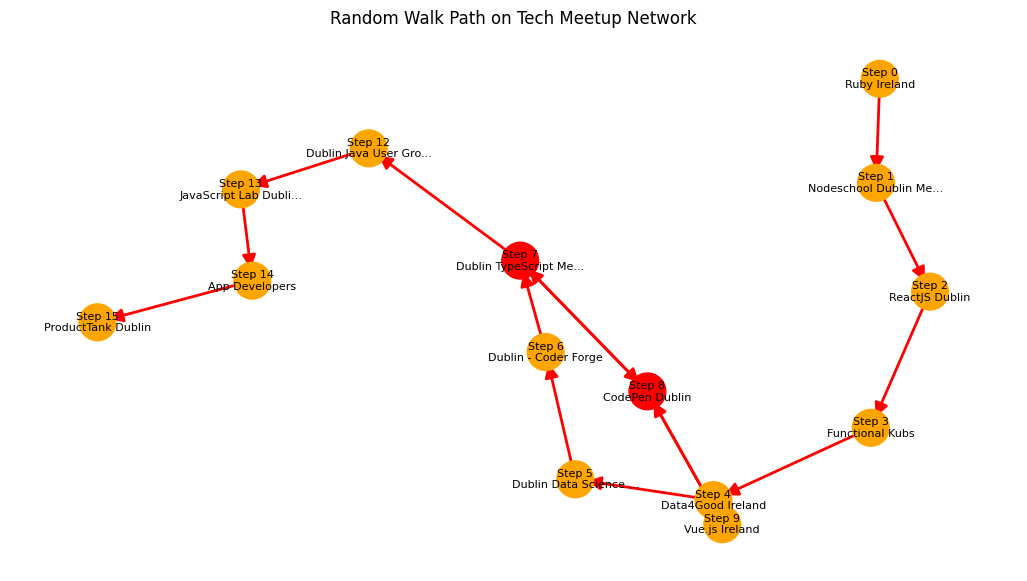

In [112]:
plot_enhanced_walk_with_names(walk, df_meta)


This graph shows the path of a random walker through the Tech Meetup network.
Each circle is a Meetup group. The number shows the order in which it was visited.
Orange circles were visited once. Red ones were visited more than once — these are important groups that the walker comes back to (like Dublin TypeScript Meetup and CodePen Dublin).

All the visited groups are Tech groups. This shows two important things:

The content is focused: All the meetups are about technology. Some talk about programming languages (like JavaScript, Java, TypeScript, Ruby), others about tools (like React, Vue.js, CodePen), and some are learning communities (like Nodeschool or Coder Forge).

Everything is well connected: The walker easily moves from one topic to another. This means Tech groups are not just similar in theme — they are also connected to each other in the network.

Even in just 15 steps, the walker visits many different kinds of Tech groups — from coding to data science, and even groups with social goals (like Data4Good).

This supports what we saw before:
Tech groups cover many topics, but are still strongly connected to each other.

In [104]:
walk_ids = walk


In [103]:
df_meta.loc[walk_ids][["name", "categories", "description"]]


,name,categories,description
Id,,,
68,Ruby Ireland,[Tech],Ruby Ireland is a developer group for anyone i...
71,Nodeschool Dublin Meetup,[Tech],This is a group dedicated to teaching people h...
602,ReactJS Dublin,[Tech],ReactJS Dublin is a quarterly ish meetup for t...
296,Functional Kubs,[Tech],This is a group for anyone interested in Funct...
613,Data4Good Ireland,[Tech],We re a collection of data scientists collabor...
883,Dublin Data Science Beginners Meetup,[Tech],Goal Encourage and provide a helping hand to t...
73,Dublin - Coder Forge,[Tech],A place to learn how to forge out code to smyt...
39,Dublin TypeScript Meetup,[Tech],TypeScript is a typed superset of JavaScript t...
722,CodePen Dublin,[Tech],CodePen is a playground for the front end side...


# Conclusion and future work

In this project, we used network analysis to study the Meetup community in Dublin. We found clear differences between Tech and Non-Tech groups, both in how they are connected and in the topics they cover. With text analysis and category data, we were able to give meaningful labels to each group and better understand their role in the network.

Since the network is static (it doesn’t include time information), we couldn’t study how meetups change over time. In the future, it would be useful to include time data to see how groups grow or change. We could also build a multilayer network, where Tech and Non-Tech events are in different layers. Another idea is to study groups of three or more meetups that often share members—these patterns could show stronger hidden connections. Finally, this kind of analysis could be done in other cities to compare how communities form in different places.